# Определение возраста покупателей

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:**

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


## Исследовательский анализ данных

В начале просто посмотрим на данные

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#настроим параметры отображения графиков
sns.set(rc={"figure.figsize": (16, 10)})
sns.set_style("whitegrid")

Загрузим данные

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

display(labels.head())
display(labels.info())
display(labels.shape)

Found 7591 validated image filenames.


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

(7591, 2)

<div class="alert alert-block alert-success">
<b>Успех:</b> Радует, что ты не забываешь про первичный анализ загруженных файлов.
</div>

В датасете у нас есть 7591 фотогарфий. 25% мы отведем под валидационную выборку. итого для обучения у нас будет 5693 фото. Я думаю этого долно хватить для модели. 

ДАлее посмотримт на то какие данные у нас есть по возрасту. Есть ли у нас перекос в данных или озможные аномалии.

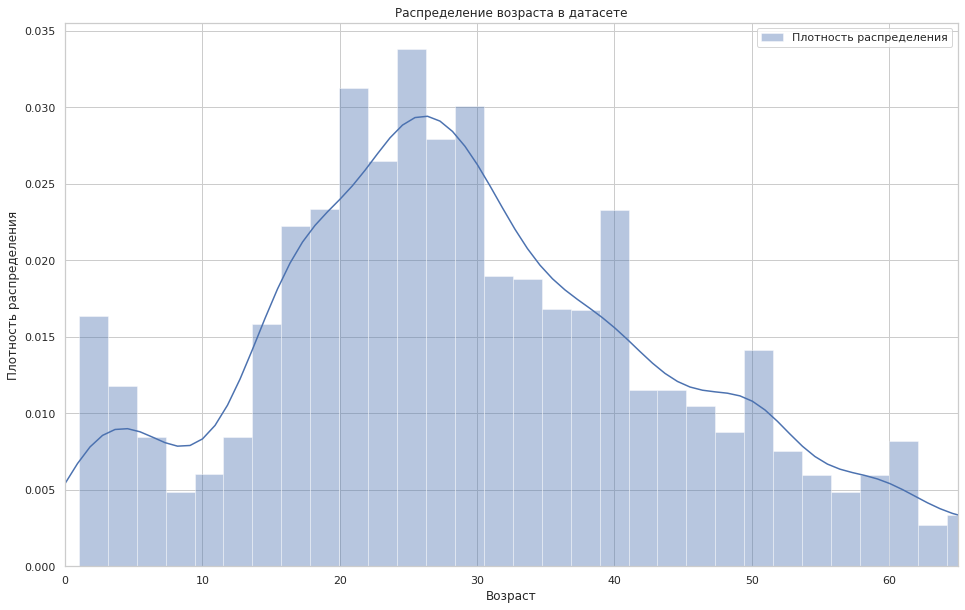

In [4]:
sns.distplot(labels['real_age'], color='b', label='Плотность распределения')
plt.xlim(0, 65)
plt.title('Распределение возраста в датасете')
plt.xlabel('Возраст')
plt.ylabel('Плотность распределения')
plt.legend()

plt.show()

Мы видим, что распределение у нас не совсем нормальное. у нас есть просадка по данным для 9 лет. Помимо этого достаточно много данных для совсем маленьких детей. данных по людям от 14 до 40 лет достатчно, я думаю для второй нашей задачи это самое главные данные. Также видно, что данные смещены вправо: пожилых покупателей не так много. Но думаю все равно мы сможем поделить покупателей на группы. 

далее посмотрим несоклько фото из датасета чтобы понять с чем мы имеем дело. 

In [5]:
# Возьмём из итератора один батч
images = next(train_gen_flow)

In [6]:
# размер батча с изображениями
images[0].shape

(32, 224, 224, 3)

In [7]:
def remove_ticks():
    """Убирает оси с изображения."""
    plt.xticks([])
    plt.yticks([])

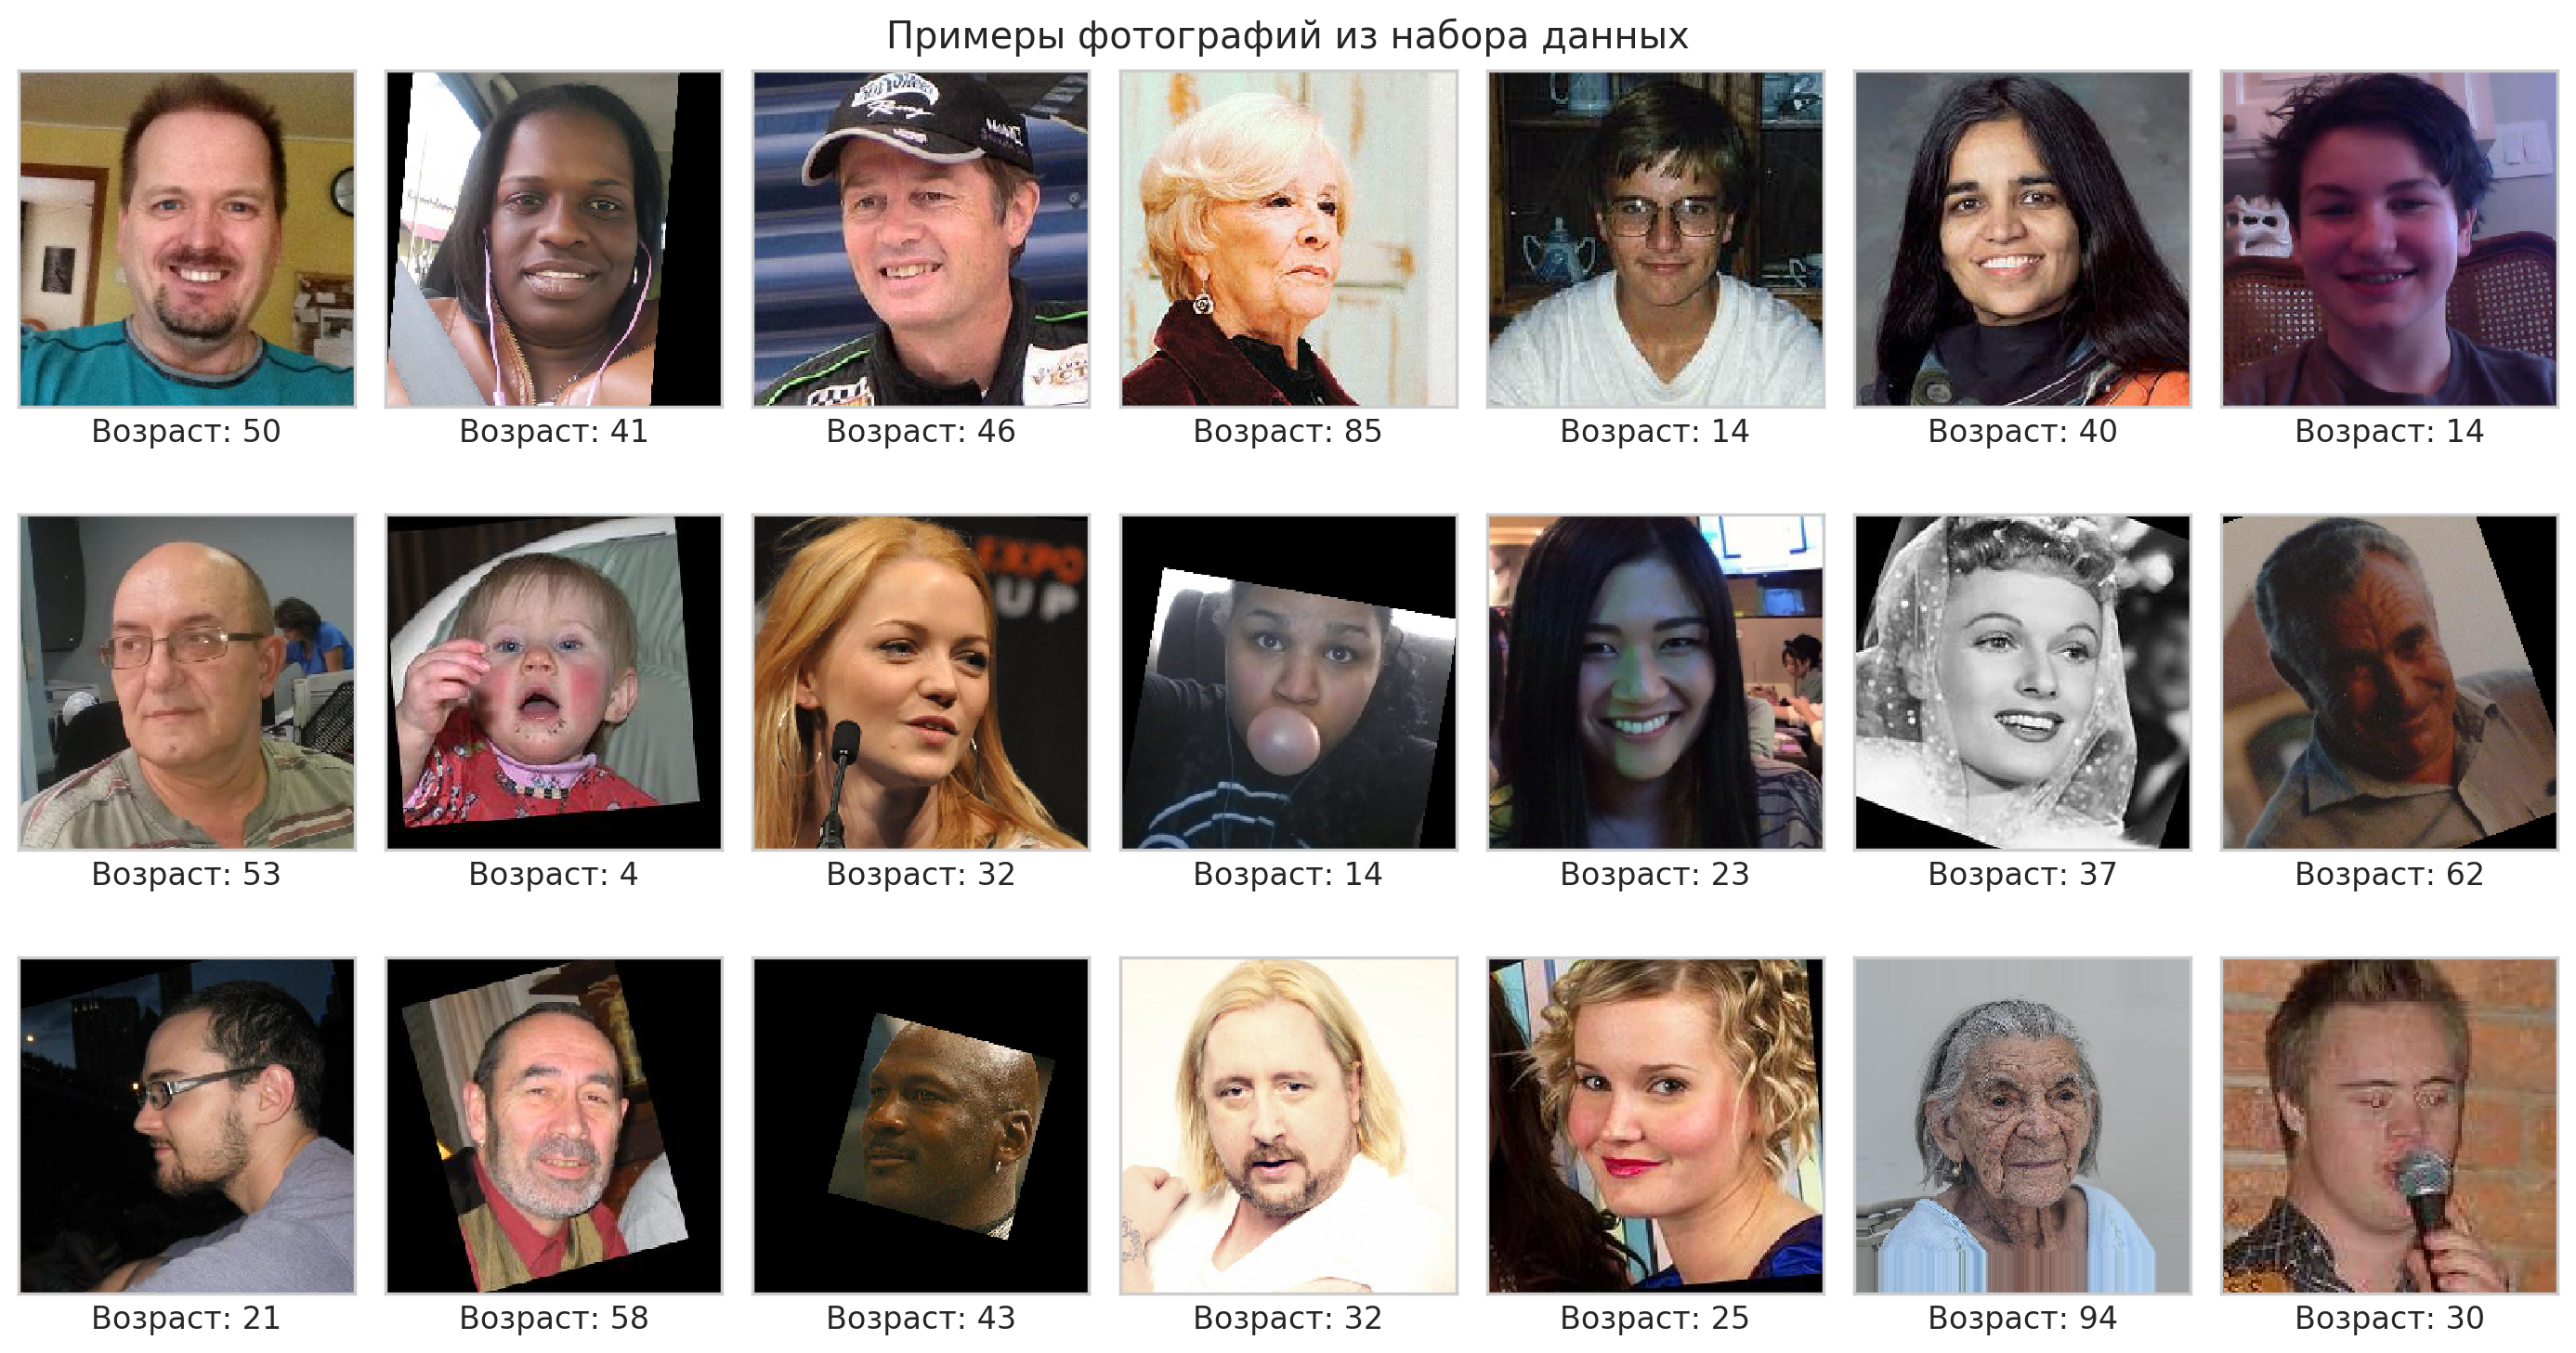

In [8]:
# Рисуем фотографии вместе с возрастом
plt.figure(figsize=(14, 7.5), dpi=200)
for (i, img), label in zip(enumerate(images[0][:21]), images[1]):
    plt.subplot(3, 7, i + 1)
    plt.imshow(img)
    remove_ticks()
    plt.xlabel(f'Возраст: {label}')
plt.suptitle('Примеры фотографий из набора данных')
plt.tight_layout(pad=1)
plt.show()
plt.close()

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory = f'{path}final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training',)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory = f'{path}final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation')

    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):
    # features_train, target_train = train_data
    # features_test, target_test = test_data
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

```

Train for 178 steps, validate for 60 steps
Epoch 1/7
2021-07-09 22:06:49.685220: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-09 22:06:49.963765: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 44s - loss: 232.2380 - mae: 10.8632 - val_loss: 910.6999 - val_mae: 25.3533
Epoch 2/7
178/178 - 37s - loss: 74.8580 - mae: 6.4939 - val_loss: 821.8782 - val_mae: 23.7244
Epoch 3/7
178/178 - 37s - loss: 49.3856 - mae: 5.3037 - val_loss: 179.8253 - val_mae: 10.0833
Epoch 4/7
178/178 - 37s - loss: 35.8635 - mae: 4.5349 - val_loss: 185.2277 - val_mae: 10.3113
Epoch 5/7
178/178 - 37s - loss: 28.5456 - mae: 4.0551 - val_loss: 78.4465 - val_mae: 6.7075
Epoch 6/7
178/178 - 37s - loss: 21.2154 - mae: 3.5317 - val_loss: 69.8160 - val_mae: 6.4680
Epoch 7/7
178/178 - 37s - loss: 16.9007 - mae: 3.1649 - val_loss: 67.6549 - val_mae: 6.2228
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 67.6549 - mae: 6.2228
Test MAE: 6.2228

```

## Анализ обученной модели

Мы проанализирвали имеющиеся данные, посотрели на фотографии, оуенили количество данных и их распределние. 

Далее с использовали архитектеру ResNet50 для предсказания возраста человека на фото. в итоге МАЕ у нас получлось - 6.222, что для нас вполне неплохо. Чтобы добиться лучшего резальтата, можно было-бы попробовать поменять контрастность или увеличить количество эпох, но это бы увеличило время работы модели. Если задача стояла добиться МАЕ меньше 8, то мы ее вполне выполнили. 

- Если говорить о первом задании (определить группы покупателй), то 6 лет не такой большой разброс и в целом все делять аудиторию на тех кто моложе 18, далее средний возраст до 35 лет и далее выше. При таких границах групп наша модель должна работать нормально. Главное чтобы таких групп не было ильно много, тогда модель будет работать корректно.

- Второе задание по контролю кассиров. Разброс слишком большой и думал для этой заданич наша модель не подойдет, либо это должны быть какие-то совсем экстримальны езначения (очень молодые покупатели). Так что паспорт лучше спрашивать у всех.
